## Analysis notebook for Thompson Sampling of PETase strains

In [ ]:
%load_ext autoreload
%autoreload 2

In [3]:
import arviz
import ipywidgets
from matplotlib import cm, pyplot
import numpy
import os
import pandas
import pathlib
import pickle

try:
    import pymc3
except:
    import pymc as pymc3

import calibr8
import cutisplit
import pyrff
import retl
import robotools
import scipy

import run_analysis

In [4]:
%load_ext watermark
%watermark --iversions

matplotlib: 3.4.3
arviz     : 0.11.4
ipywidgets: 7.6.5
numpy     : 1.20.3
robotools : 1.1.0
scipy     : 1.7.1
pandas    : 1.3.4
calibr8   : 6.1.0
pyrff     : 2.0.1
cutisplit : 0.2.0
retl      : 0.3.1
pymc      : 4.0.0



In [56]:
RUN_ID = "C9NBYQ"
resultpath = f'{RUN_ID}_Results' 
cm_nitrophenol = cutisplit.NitrophenolAbsorbanceModel.load(rf"{resultpath}\{RUN_ID}_cm_nitrophenol.json")
calibr8.plot_model(cm_nitrophenol)


df_inputs, df_kinetics = run_analysis.read_rounds(["C5PA33", "C9NBYQ"])

C:\Users\helleckes\AppData\Local\Continuum\miniconda3\envs\dibecs_6.0.1\lib\site-packages\numpy\core\_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)


## Creating the Model

In [33]:
model = cutisplit.LongFormModel(
    df_inputs,
    df_kinetics=df_kinetics,
    cm_nitrophenol=cm_nitrophenol,
)
# the shapes of the dataset are encoded in the "coords" of the underlying PyMC3 model:
model.summary()

strain              (24,)	AbnA, AmyE, AprE, …, YwmC
culture_id          (54,)	C5PA33_A02, C5PA33_A04, C5PA33_A05, …, C9NBYQ_F07
kinetic_id          (216,)	C5PA33_1_B02, C5PA33_1_B03, C5PA33_1_B04, …, C9NBYQ_2_G11
column_id           (10,)	2, 3, 4, …, 11
cutinase_cycle      (30,)	0, 1, 2, …, 29


The PyMC3 model can be visualized as a graph:

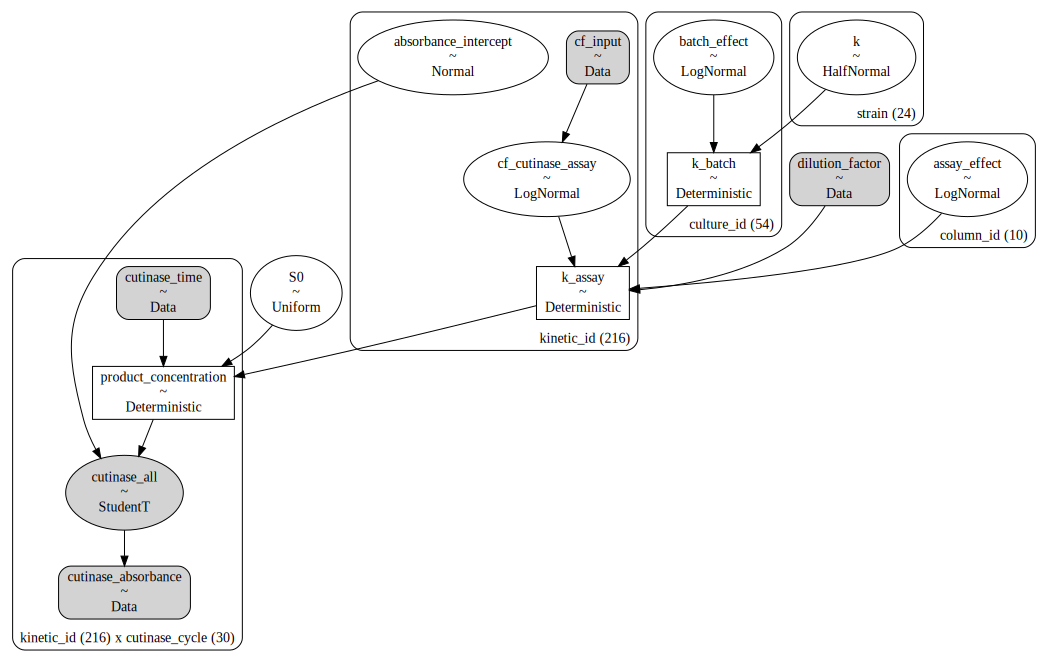

In [34]:
pymc3.model_to_graphviz(model.pmodel)

In [35]:
with model.pmodel:
    idata = pymc3.sample(return_inferencedata=True, target_accept=0.9)
idata

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [cf_cutinase_assay, k, batch_effect, assay_effect, S0, absorbance_intercept]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 616 seconds.
The number of effective samples is smaller than 25% for some parameters.


Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats
	> observed_data
	> constant_data

The result should be saved such that the analysis can run in another notebook.

In [52]:
idata.to_netcdf(fr"{resultpath}\{RUN_ID}_result_35degree-PeH.nc")

'C9NBYQ_Results\\C9NBYQ_result_35degree-PeH.nc'

Execute the next cell in case you want to reload saved data

In [ ]:
idata = arviz.from_netcdf("BZP1XQ_Results\BZP1XQ_result_hierarchical_greaterSD.nc")

In [36]:
arviz.plot_trace(idata, var_names=[
    "k_assay", "S0", "k", "k_batch", "absorbance_intercept", "assay_effect"
]);
pyplot.tight_layout()
# The left subplots show the posterior probability density.
# The right subplots show the MCMC. If they look like random noise everything is fine.
# The linestyle corresponds to independent MCMC chains - they should come to the same result.

C:\Users\helleckes\AppData\Local\Continuum\miniconda3\envs\dibecs_6.0.1\lib\site-packages\arviz\plots\backends\matplotlib\pairplot.py:238: UserWarning: rcParams['plot.max_subplots'] (144) is smaller than the number of resulting pair plots with these variables, generating only a 16x16 grid
  warnings.warn(


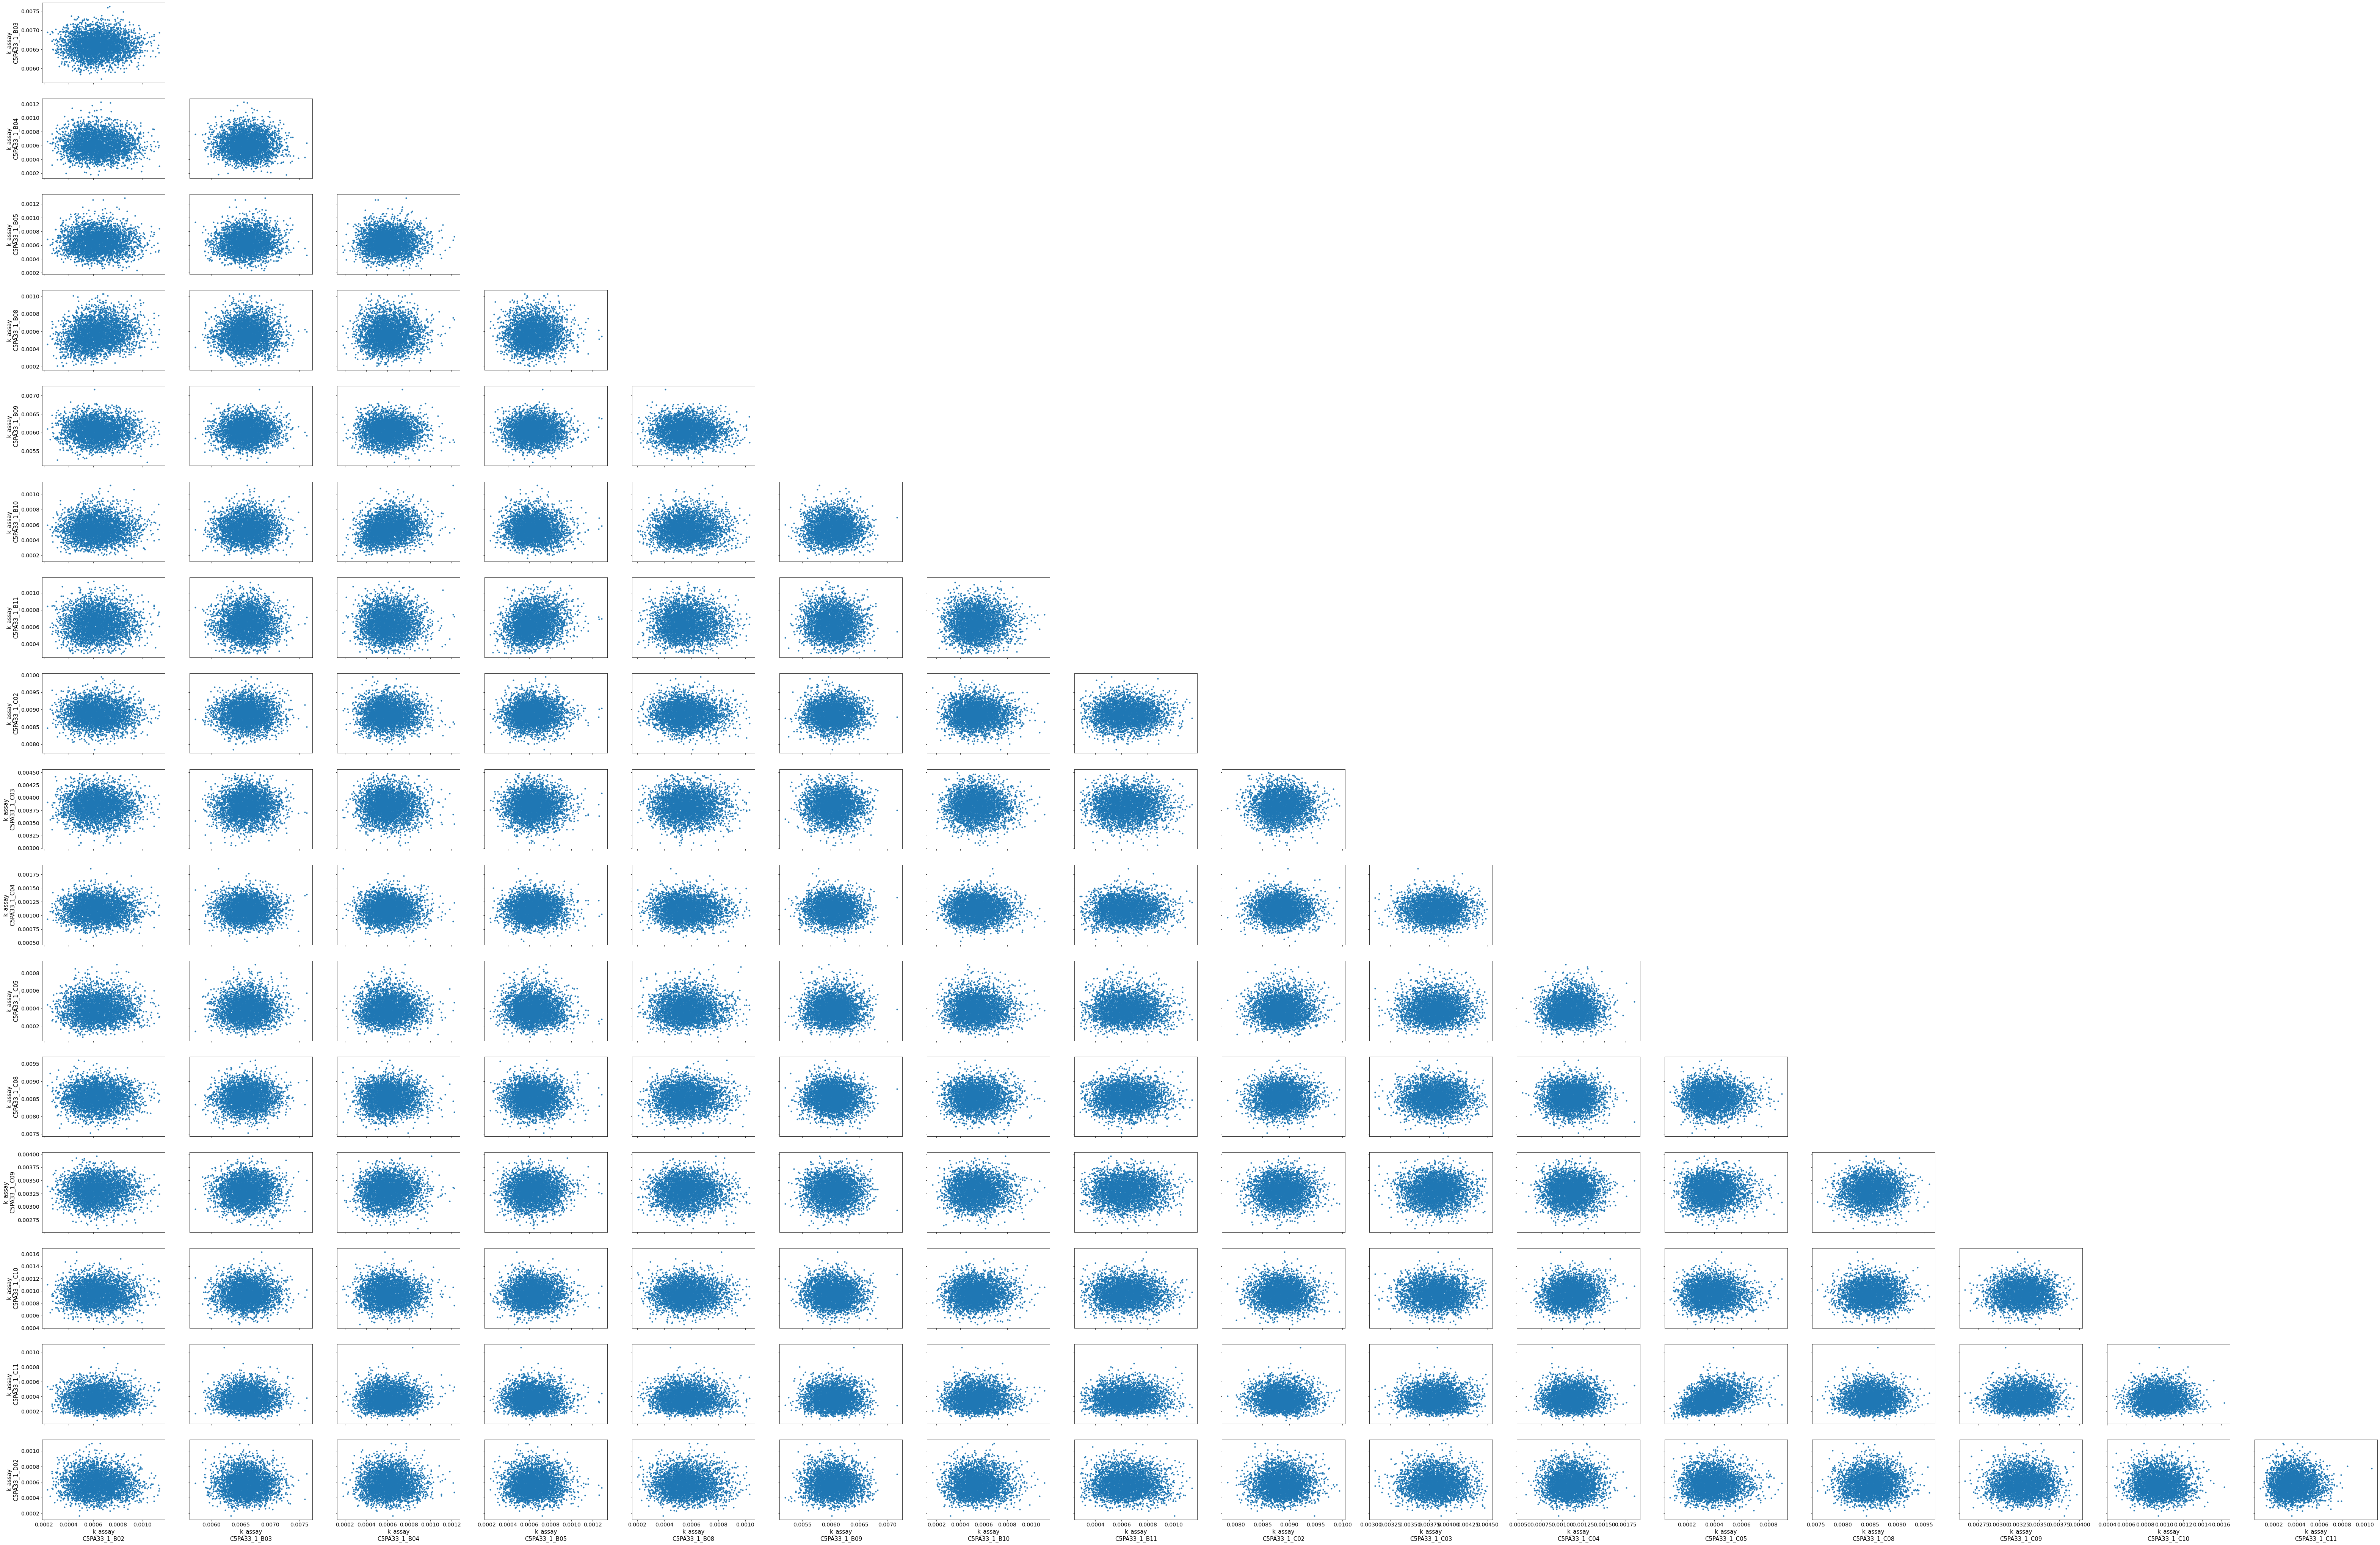

In [37]:
arviz.rcParams['plot.max_subplots'] = 144
arviz.plot_pair(idata, var_names=[
    "k_assay", 
    "k", "k_batch", "S0", 
    "absorbance_intercept"
]);

In [38]:
arviz.plot_forest(idata, var_names=["k_batch"], combined=True)
arviz.plot_forest(idata, var_names=["k_assay"], combined=True)

array([<AxesSubplot:title={'center':'94.0% HDI'}>], dtype=object)

array([<AxesSubplot:title={'center':'94.0% HDI'}>], dtype=object)

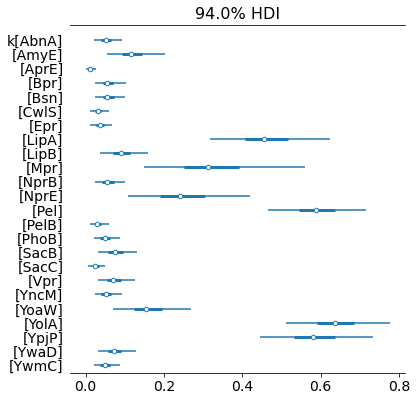

In [39]:
arviz.plot_forest(idata, var_names=["k"], combined=True)

In [40]:
arviz.plot_forest(idata, var_names=["assay_effect"], combined=True)

array([<AxesSubplot:title={'center':'94.0% HDI'}>], dtype=object)

In [41]:
posterior = idata.posterior.stack(sample=("chain", "draw"))
posterior

<xarray.Dataset>
Dimensions:                (column_id: 10, culture_id: 54, cutinase_cycle: 30, kinetic_id: 216, sample: 4000, strain: 24)
Coordinates:
  * kinetic_id             (kinetic_id) <U12 'C5PA33_1_B02' ... 'C9NBYQ_2_G11'
  * strain                 (strain) <U4 'AbnA' 'AmyE' 'AprE' ... 'YwaD' 'YwmC'
  * culture_id             (culture_id) <U10 'C5PA33_A02' ... 'C9NBYQ_F07'
  * column_id              (column_id) int32 2 3 4 5 6 7 8 9 10 11
  * cutinase_cycle         (cutinase_cycle) int32 0 1 2 3 4 5 ... 25 26 27 28 29
  * sample                 (sample) MultiIndex
  - chain                  (sample) int64 0 0 0 0 0 0 0 0 0 ... 3 3 3 3 3 3 3 3
  - draw                   (sample) int64 0 1 2 3 4 5 ... 995 996 997 998 999
Data variables:
    cf_cutinase_assay      (kinetic_id, sample) float64 0.7579 1.032 ... 0.92
    k                      (strain, sample) float64 0.08663 0.05509 ... 0.06064
    batch_effect           (culture_id, sample) float64 0.7179 0.7715 ... 0.8201
    assay_effect           (column_id, sample) float64 0.9833 0.9634 ... 1.018
    S0                     (sample) float64 0.6993 0.6996 ... 0.6994 0.6998
    absorbance_intercept   (kinetic_id, sample) float64 0.3822 0.3832 ... 0.297
    k_batch                (culture_id, sample) float64 0.06515 ... 0.4585
    k_assay                (kinetic_id, sample) float64 0.0006744 ... 0.008845
    product_concentration  (kinetic_id, cutinase_cycle, sample) float64 0.0 ....
Attributes:
    created_at:                 2021-10-27T12:32:21.007532
    arviz_version:              0.11.4
    inference_library:          pymc
    inference_library_version:  4.0.0
    sampling_time:              616.4587292671204
    tuning_steps:               1000

In [50]:
strains = numpy.unique(df_inputs.strain.values)
numpy.random.seed(20211026)
selected_strains = pyrff.sample_batch(
    posterior.k.values,
    ids=strains,
    batch_size=12,
    correlated=True
)
numpy.unique(selected_strains, return_counts=True)

(array(['LipA', 'Pel', 'YolA', 'YpjP'], dtype='<U4'),
 array([1, 4, 4, 3], dtype=int64))

In [48]:
selected_strains_shuffled = numpy.copy(selected_strains)
numpy.random.shuffle(selected_strains_shuffled)
wells = [f"{l}{n:02d}" for n in [1,8] for l in "ABCDEF" ] 
inoculation_dict = {
    well: strain 
    for well, strain in zip(wells, selected_strains_shuffled)
}
inoculation_dict

{'A01': 'YolA',
 'B01': 'YolA',
 'C01': 'YolA',
 'D01': 'YolA',
 'E01': 'Pel',
 'F01': 'YolA',
 'A08': 'YolA',
 'B08': 'YpjP',
 'C08': 'LipA',
 'D08': 'Pel',
 'E08': 'YolA',
 'F08': 'Pel'}

In [44]:
probs = pyrff.sampling_probabilities(
    posterior.k.values,
    correlated=True
)

In [51]:
fig, ax = pyplot.subplots(figsize=(12,3), dpi=120)
ax.bar(x=numpy.arange(len(probs)), height=probs,)
ax.set(
    xticks=numpy.arange(len(probs)), 
    xticklabels=numpy.unique(df_inputs.strain.values),
    xlim=(-0.2,23.2),
)
ax.set_title("Thompson Probabilities")
pyplot.tight_layout()

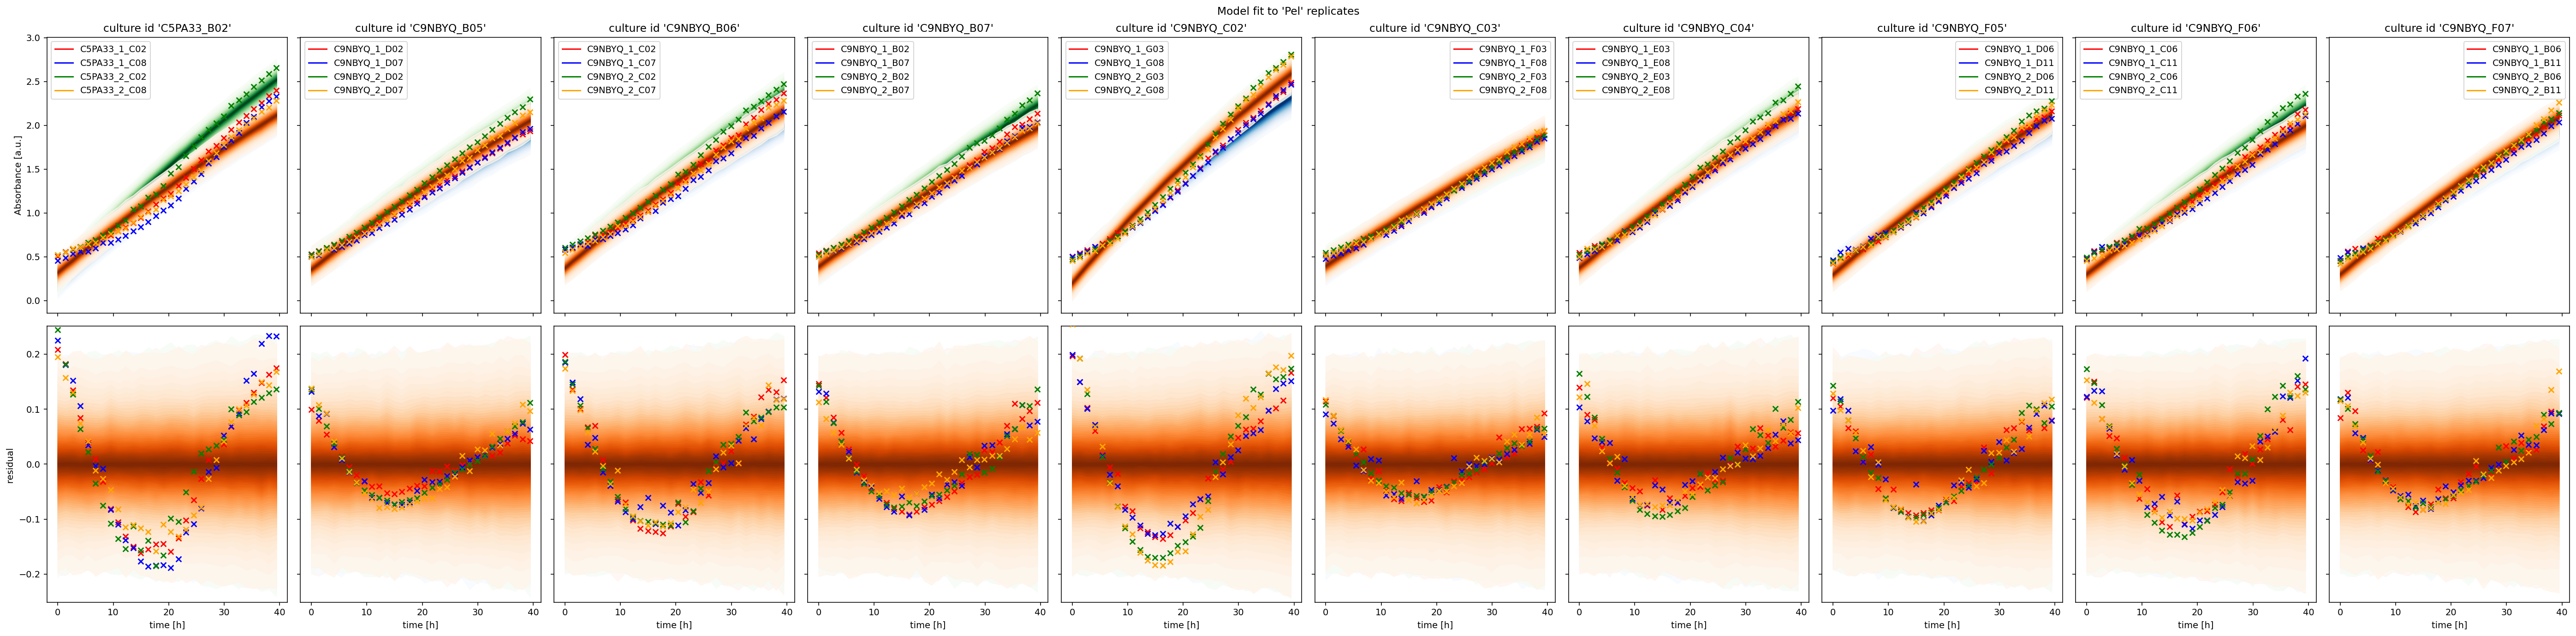

In [58]:
#for strain in posterior.strains.values:
strain="Pel"
culture_ids = df_inputs[df_inputs.strain==strain].index.to_list()
fig, axs = pyplot.subplots(
        dpi=140,
        figsize=( 4*len(culture_ids), 10),
        ncols=len(culture_ids),
        nrows=2,
        sharey="row",
        sharex="col",
        squeeze=False,
    )
for c, cid in enumerate(culture_ids):
    df = df_kinetics[df_kinetics.culture_id==cid]
    kinetic_ids = df.index
    residual_ptp = 0
    for r, (kid, (color, cmap)) in enumerate(zip(kinetic_ids, [
        ("red", "Reds"),
        ("blue", "Blues"),
        ("green", "Greens"),
        ("orange", "Oranges"),
    ])):


        # and the actual absorbance
        absorbance = idata.constant_data.cutinase_absorbance.sel(kinetic_id=kid)
        #print(color, kid, cid)
        
        axs[0,c].scatter(
            idata.constant_data.cutinase_time.values[0,:],
            absorbance,
            marker="x",
            color=color,
            zorder=10
        )
        theta = [
            posterior.absorbance_intercept.sel(kinetic_id=kid).values
        ] + list(cm_nitrophenol.theta_fitted[1:])
        loc, scale, df = cm_nitrophenol.predict_dependent(
            posterior.product_concentration.sel(kinetic_id=kid).values,
            theta=theta
            
        )
        pp_samples = scipy.stats.t.rvs(loc=loc, scale=scale, df=df)

        pymc3.gp.util.plot_gp_dist(
            ax=axs[0,c],
            samples=pp_samples.T,
            x=idata.constant_data.cutinase_time.values[0,:],
            palette=cmap,
            plot_samples=False,
        )
        
        #residuals
        median = numpy.median(pp_samples, axis=1)
        residuals = absorbance.values - median
        residual_ptp = max(residual_ptp, numpy.ptp(residuals))

        pymc3.gp.util.plot_gp_dist(
            ax=axs[1, c],
            samples=(pp_samples - median[:,None]).T,
            x=idata.constant_data.cutinase_time.values[0,:],
            plot_samples=False,
            palette=cmap
        )
        axs[1, c].scatter(
            idata.constant_data.cutinase_time.values[0,:], residuals, marker="x", color=color, zorder=10
        )
        axs[0, c].plot([], [], color=color, label=kid)
    # formatting
    axs[0, c].set_title(f"culture id '{cid}'")
    axs[1, c].set_xlabel("time [h]") 
    axs[0, c].legend()

axs[0, 0].set_ylabel(
    "Absorbance [a.u.]"
)
axs[1, 0].set_ylim(-residual_ptp, residual_ptp)
axs[1, 0].set_ylabel("residual ")
fig.suptitle(
    f"Model fit to '{strain}' replicates"
)
fig.tight_layout()